# Learning from linear data (plus noise)

Welcome to this notebook. The author is Paulo Abelha (http://www.pauloabelha.com)

This notebook should be available on my GitHub http://ww.github.com/pauloabelha/notebooks

In this module you will learn four approaches to linear regression. The idea is start simple, but principled; working our way up the abstractions. Therefore we deal with the "hello world" of Machine Learning: Linear regression

Unless explictly noted, all code and writing in here is of my own authorship 

Main Resources:
- Wikipedia (please donate to Wikipedia)
- This great paper: MacKay, David JC. "Bayesian interpolation." Neural computation 4.3 (1992): 415-447.
- David Mackay's bible was a great resource: http://www.inference.org.uk/mackay/itila/book.html
- Another great book: http://www.gaussianprocess.org/gpml/
- Yet another great book: http://www.deeplearningbook.org/
- Nice cookbook for matrices: http://compbio.fmph.uniba.sk/vyuka/ml/old/2008/handouts/matrix-cookbook.pdf
- Detailed derivations for oepration on Gaussians: http://www.tina-vision.net/docs/memos/2003-003.pdf

Here we compare four different Machine Learning approaches for fitting a function to noisy linear data
- Linear Regression
- Bayesian Linear Regression
- Neural Networks
- Gaussian Processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from matplotlib.patches import Ellipse
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# for reproducibility
random_seed_ix = 1
np.random.seed(random_seed_ix)
# number of data points
n_pts = 100
n_dims = 1
# noise (variance of Gaussian distribution for noise)
# sample the noise uniformly at random in [0, 1) and divide by 10
sigma_v_sq = np.random.rand(n_dims,1)/10.0
sigma_v_sq = sigma_v_sq[0,0]
# sample a weight uniformly at random in [0, 1)
w_1 = np.random.rand(n_dims,1)
# sample a bias uniformly at random in [0, 1)
b = np.random.rand()
# the X values
X = np.random.rand(n_pts,n_dims)

**1.1 Helper Functions**

In [2]:
# plot a cooolwarm surface given an m x n matrix Z with values 
# range_x: a 2-element vector/list with the minimum and maximum values in the x axis
# range_y: analogous to range_x, but for the y axis
def my_plot_3Dsurf(range_x,range_y,Z,label_x = 'x',label_y = 'y', viewpoint = 111, fontsize_x = 18, fontsize_y = 18):
    x = np.linspace(range_x[0], range_x[1], Z.shape[0])
    y = np.linspace(range_y[0], range_y[1], Z.shape[1])
    xv, yv = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(viewpoint, projection='3d')
    ax.plot_surface(xv, yv, Z, cmap=cm.coolwarm)
    plt.xlabel(label_x, fontsize=fontsize_x)
    plt.ylabel(label_y, fontsize=fontsize_y)
    plt.show()

In [3]:
# plot a heatmap given an m x n matrix Z with values
def plot_heatmap(Z, cmap = 'cool', extent = [0,1,0,1]):
    plt.imshow(np.reshape(Z, (Z.shape[0],-1)), cmap, interpolation='nearest', extent = extent)
    plt.show()

In [4]:
# Plot a bivariate Gaussian with contours representing multiples of standard deviation isolines
# Resources:
#     https://en.wikipedia.org/wiki/Multivariate_normal_distribution
#     http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/
def plot_bivariate_gaussian_isolines(mean, covar_mtx, N, colour = 'k', plot_fig = True, ax_lims = -1):
    assert(mean.shape == (2, 1))
    assert(covar_mtx.shape == (2, 2))
    assert(N > 0)
    # perform Eigen decomposition to get rotation of Gaussian
    w, U = np.linalg.eig(covar_likelihood)  
    # get index of largest eigenvalue
    max_eig_value_ix = np.argmax(w)
    # get the x and y value of the eigenvector corresponding to largest eigenvalue
    v1x = U[0,max_eig_value_ix]
    v1y = U[1,max_eig_value_ix]
    # get alpha, the angle of rotation for the Gaussian
    alpha = np.arctan(v1y/v1x)
    # get figure
    fig = plt.figure(0)
    # create axes object
    ax = fig.add_subplot(111, aspect='equal')
    # initialise an empty list for the ellipses
    E = []
    # construct ellipses with increasing multiples of standard deviation contours  
    e_centre = mean
    e_width_orig = 2.0*np.sqrt(covar_mtx[0,0])
    e_height_orig = 2.0*np.sqrt(covar_mtx[1,1])
    for i in range(N):        
        e_width = (i+1)*e_width_orig
        e_height = (i+1)*e_height_orig
        e = Ellipse(e_centre, width=e_width, height=e_height, angle=alpha*(180.0/np.pi))
        e.set_clip_box(ax.bbox)
        e.set_fill(0)
        e.set_facecolor(colour)
        E.append(e)
        # add elipse and axes limits
        ax.add_artist(E[i])    
    # add the central point (as an extra small full ellipse )
    e = Ellipse(e_centre, width=e_width_orig/10.0, height=e_height_orig/10.0, angle=alpha*(180.0/np.pi))
    e.set_clip_box(ax.bbox)
    e.set_fill(1)
    e.set_facecolor(colour)
    ax.add_artist(e)  
    # adjust the axes limits (or use provided ones)
    ax_lim_mult = 1.5
    if ax_lims == -1:      
        ax_lims = [0, 0, 0, 0]
        lim = N*ax_lim_mult*max(np.sqrt(covar_mtx[0,0]),np.sqrt(covar_mtx[1,1]))
        ax_lims[0] = mean[0,0]-lim
        ax_lims[1] = mean[0,0]+lim
        ax_lims[2] = mean[1,0]-lim
        ax_lims[3] = mean[1,0]+lim        
    # set axes limits    
    ax.set_xlim(ax_lims[0], ax_lims[1])
    ax.set_ylim(ax_lims[2], ax_lims[3])    
    #plot
    if plot_fig:
        plt.show()
    return fig, ax, ax_lims

**1.1 - Linear Model for Generating Data**

Here we:
- a) Define our linear model assumptions about data generation
- b) Define the function for generating the data
- c) Plot the data and information about it (matrices' shapes and value for the weight w and bias b)

a) Define our linear model and assumptions

In [5]:
%%latex
We assume our data is generated by a one-dimensional linear function:
$$ \mathbf{y} = \mathbf{X} w_1 + b $$
$\mathbf{X}$ is a $N \times m$ matrix where each row is an $m$-dimensional input and $N$ is the number of inputs.
To simplify notation and derivations we encode the weight $w_1$ and the bias $b$ into the same vector $\mathbf{w} = (w_1,b)^\top$.
We then augment the inputs in $\mathbf{X}$ by adding an extra column with $1$ at every entry. Our function then becomes:
$$ \mathbf{y} = \mathbf{X_b}\mathbf{w} $$
Finally, we further assume there is also some Gaussian noise in the data generation:
$$ \mathbf{y} = \mathbf{X_b}\mathbf{w} + v_m $$    
$$ v_m \sim N(0,\sigma_v^2) $$ 

<IPython.core.display.Latex object>

b) Implement the linear model and the noisy linear model

In [6]:
# the linear model y = X*w + b using the encoded bias (y = X_b*w)
# sigma_sq_v is the variance of our Gaussian noise model
def my_linear_model(X_b,w):
    # ensure the matrix multiplication can be performed
    assert(X_b.shape[1] == w.shape[0])
    y = np.dot(X_b,w)
    return y

In [7]:
# here we encode our data
# get X as a random matrix
def my_noisy_linear_model(X,n_pts,n_dims,sigma_v_sq):
    # add one extra all-ones column for the bias
    X_b = np.hstack((X,np.ones((n_pts,1)))) 
    # get full weight vector
    w = np.zeros((2,1))
    w[0,0] = w_1
    w[1,0] = b
    # sample N noise values (N=n_pts)
    noise_vec = np.random.normal(0,sigma_v_sq,(n_pts,1)) 
    y = my_linear_model(X_b,w) + noise_vec
    return X_b, y, w, noise_vec

X_b, y, w, noise_vec = my_noisy_linear_model(X,n_pts,1,sigma_v_sq)

c) Plot the noisy linear data

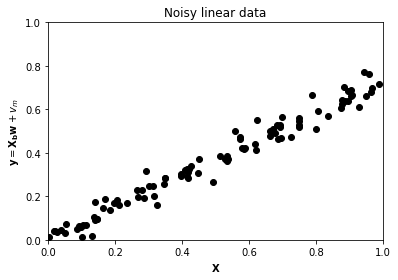

w_1 = 0.720324493442
b = 0.000114374817345
noise (variance) = 0.0417022004703


In [8]:
# plot the data and the true parameters (w, b and noise variance) for the generation
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xlabel('$\mathbf{X}$')
ax.set_ylabel('$\mathbf{y}=\mathbf{X_b}\mathbf{w} + v_m$')
plt.title('Noisy linear data')
plt.scatter(X,y,color = 'k')
plt.show()
print("w_1 = " + str(w[0,0]))
print("b = " + str(w[1,0]))
print("noise (variance) = " + str(sigma_v_sq))

**1.2 - Linear Regresion**

Time to learn.

In order to perform linear regression, we:
- a) Define and implement our loss function as mean squared errors
- b) Derive and implement linear regression
- c) Perform Linear Regresion on the generated data
- d) Plot the fit in data space
- e) Plot the loss function in parameter space

a) Define and implement our loss function as mean squared errors

In [52]:
%%latex
We define our loss function as mean squared error between the groundtruth outputs $\mathbf{y}$ and the predicted outputs $\mathbf{\hat{y}}$. 
The loss function is parameterised by an estimated weight vector $\mathbf{\hat{w}}$.
$$ J(D; \mathbf{\hat{w}}) = \frac{1}{N} \sum_{i=1}^{N} (\mathbf{\hat{y}}_i-\mathbf{y}_i)^2 $$
$ D $ is our data containing $\mathbf{X_b}$ and $\mathbf{y}$, where $ \mathbf{\hat{y}} = \mathbf{X_b}\mathbf{\hat{w}} $
$$$$
The loss function can also be written as the euclidean norm of the difference:
$$ J(D; \mathbf{\hat{w}}) = \frac{1}{N} \lVert\mathbf{\hat{y}}-\mathbf{y}\rVert_2^2 $$


<IPython.core.display.Latex object>

In [10]:
# return the mean squared error given a set of groundtruth outputs (y) and a set of predictions (y_hat)
def my_mse(y,y_hat):
    N = y_hat.shape[0]
    mse = (1.0/N)*np.sum(np.power(y_hat-y,2))
    return mse    

b) Derive and implement linear regression

In [60]:
%%latex
We want to minimise the error therefore we need to minimise $J(D; \mathbf{\hat{w}})$.
Thankfully, $J(D; \mathbf{\hat{w}})$ is convex and we can find the minimum by finding the point where the 
gradient is $0$. It is beyond the scope now to show that $J(D; \mathbf{\hat{w}})$ is convex.
$$$$
The derivation (step by step):
$$\nabla_{\mathbf{\hat{w}}}[J(D; \mathbf{\hat{w}})] = 0$$
$$\nabla_{\mathbf{\hat{w}}}[ \frac{1}{N} \lVert\mathbf{\hat{y}}-\mathbf{y}\rVert_2^2] = 0$$
$$\frac{1}{N} \nabla_{\mathbf{\hat{w}}}[\lVert\mathbf{\hat{y}}-\mathbf{y}\rVert_2^2] = 0$$
$$\nabla_{\mathbf{\hat{w}}}[\lVert\mathbf{\hat{y}}-\mathbf{y}\rVert_2^2] = 0$$
$$ \nabla_{\mathbf{\hat{w}}}[\lVert(\mathbf{X_b}\mathbf{\hat{w}}-\mathbf{y}_i)\rVert_2^2] = 0$$
$$ \nabla_{\mathbf{\hat{w}}}[(\mathbf{X_b}\mathbf{\hat{w}}-\mathbf{y})^{\top}(\mathbf{X_b}\mathbf{\hat{w}}-\mathbf{y})] = 0$$
$$ \nabla_{\mathbf{\hat{w}}}[(\mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top} - \mathbf{y}^{\top})(\mathbf{X_b}\mathbf{\hat{w}}-\mathbf{y})] = 0$$
$$ \nabla_{\mathbf{\hat{w}}}[(\mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}} - \mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top}\mathbf{y} - \mathbf{y}^{\top}\mathbf{X_b}\mathbf{\hat{w}} - \mathbf{y}^{\top}\mathbf{y}] = 0$$
$$ \nabla_{\mathbf{\hat{w}}}[\mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}}] - \nabla_{\mathbf{\hat{w}}}[\mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top}\mathbf{y}] - \nabla_{\mathbf{\hat{w}}}[\mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top}\mathbf{y}] - \nabla_{\mathbf{\hat{w}}}[\mathbf{y}^{\top}\mathbf{y}] = 0$$
$$ \nabla_{\mathbf{\hat{w}}}[\mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}}] = 2\mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}} $$
$$ \nabla_{\mathbf{\hat{w}}}[\mathbf{\hat{w}}^{\top}\mathbf{X_b}^{\top}\mathbf{y}] = \mathbf{X_b}_i^{\top}\mathbf{y}$$
$$ \nabla_{\mathbf{\hat{w}}}[\mathbf{y}^{\top}\mathbf{X_b}\mathbf{\hat{w}}] = \mathbf{y}^{\top}\mathbf{X_b}$$                              
$$ \nabla_{\mathbf{\hat{w}}}[\mathbf{y}^{\top}\mathbf{y}] = 0$$                              
$$\nabla_{\mathbf{\hat{w}}}[J(D; \mathbf{\hat{w}})] = 2\mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}} - \mathbf{X_b}^{\top}\mathbf{y} - \mathbf{y}^{\top}\mathbf{X_b}$$                              
$$\nabla_{\mathbf{\hat{w}}}[J(D; \mathbf{\hat{w}})] = 2\mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}} - 2 \mathbf{X_b}^{\top}\mathbf{y}$$              
$$ 2(\mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}} - \mathbf{X_b}_i^{\top}\mathbf{y}) = 0$$                                                  
$$ \mathbf{X_b}^{\top}\mathbf{X_b}\mathbf{\hat{w}} = \mathbf{X_b}_i^{\top}\mathbf{y}$$
$$ A = \mathbf{X_b}_i^{\top}\mathbf{X_b} $$
$$ A\mathbf{\hat{w}} = \mathbf{X_b}^{\top}\mathbf{y}$$
$$ A^{-1}A\mathbf{\hat{w}} = A^{-1}\mathbf{X_b}^{\top}\mathbf{y}$$
$$ I\mathbf{\hat{w}} = A^{-1}\mathbf{X_b}^{\top}\mathbf{y}$$                              
$$ \mathbf{\hat{w}} = (\mathbf{X_b}^{\top}\mathbf{X_b})^{-1}\mathbf{X_b}^{\top}\mathbf{y}$$ 

<IPython.core.display.Latex object>

In [30]:
# perform linear regression using mean squared error as loss function
# the estimated parameters are those that minimise the gradient of the loss function
#     please, do go through the derivatio above and ensure you understand every step
def my_linear_regression(X_b,y):
    assert(X_b.shape[0] == y.shape[0])
    w_pred = np.dot(np.dot(np.linalg.inv(np.dot(X_b.T,X_b)),X_b.T),y)
    return w_pred

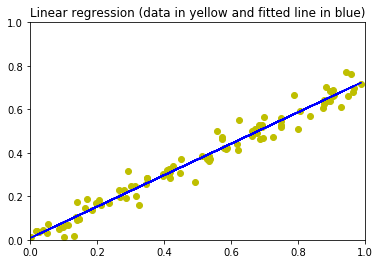

Predicted w = [[ 0.7232704 ]
 [ 0.00766488]]
Real w = [[  7.20324493e-01]
 [  1.14374817e-04]]
Mean squared error = 0.00136890403604


In [31]:
# perform linear regression on the data (X_b, y)
# X_b is an Nx2 matrix with the x inputs in the first column of X_b and an all-ones as second column
# y is an Nx1 vector with the outputs for each X_b[:,0]
def perform_and_plot_linear_regression(X_b,y):
    # perform linear regression
    w_est = my_linear_regression(X_b,y)
    # predict values with estimated parameters w_pred
    y_pred = my_linear_model(X_b,w_est)
    mse = my_mse(y,y_pred)
    # plot data and fit
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.plot(X,y_pred, color = 'b')
    plt.scatter(X, y, color = 'y')
    plt.title('Linear regression (data in yellow and fitted line in blue)')
    plt.show()
    # print information
    print("Predicted w = " + str(w_est))
    print("Real w = " + str(w))
    print("Mean squared error = " + str(mse))
    return w_est, y_pred
    
w_est, y_pred = perform_and_plot_linear_regression(X_b,y)

Computing mean squared error for 40000 pairs of weight and bias...
Best parameters (w, b) = (0.726, 0.006)
Minimum value for the error = 0.00136964525482


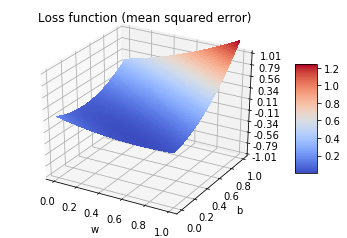

In [37]:
# vectorised code for getting many mean squared errors for a grid of different weights and biases
# also plots the resulting surface
# X_b is an Nx2 matrix with the x inputs in the first column of X_b and an all-ones as second column
# y is an Nx1 vector with the outputs for each X_b[:,0]
# (beg_w, end_w, step_w) is the range and step fro creating the grid
def plot_surf_mse(X_b,y,beg_w, end_w, step_w):
    # get number of grid rows (also number of grid columns)
    n_grid_rows = np.round((end_w-beg_w)/step_w).astype(int)
    n_grid_columns = n_grid_rows 
    n_grid_cells = n_grid_rows * n_grid_columns
    # print information on the size of grid
    print("Computing mean squared error for " + str(n_grid_cells) + " pairs of weight and bias...")    
    # get the W matrix containing the different (w, b) pairs in the specified range and step
    W = np.zeros((n_grid_rows,1))
    W[:,0] = np.arange(beg_w, end_w, step_w)
    W_grid, B_grid = np.meshgrid(W, W)
    W = np.row_stack((W_grid.reshape(1,n_grid_cells),B_grid.reshape(1,n_grid_cells)))
    # calculate the error for every (w, b) option
    Y_hat = np.dot(X_b,W)
    Y_sq_diff = np.power(Y_hat - y,2)
    R_sum = np.sum(Y_sq_diff, axis= 0)/n_pts
    R_grid = R_sum.reshape(n_grid_rows,n_grid_columns)
    # get the index of the lowest error
    min_mse_ix = np.argmin(R_sum)
    # print information on the best (w, b) option and minimum error 
    print("Best parameters (w, b) = (" + str(W[0,min_mse_ix]) + ", " + str(W[1,min_mse_ix]) + ")")
    print("Minimum value for the error = " + str(np.min(R_sum)))
    # plot the surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(W_grid, B_grid, R_grid, cmap=cm.coolwarm,linewidth=0, antialiased=False) 
    # customise axes
    ax.set_xlabel('w')
    ax.set_ylabel('b')
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    # add a nice colour bar
    fig.colorbar(surf, shrink=0.5, aspect=5)
    # customise title and show plot
    plt.title('Loss function (mean squared error)')
    plt.show()
    # return surface information
    return W_grid, B_grid, R_grid
    
_, _, _, = plot_surf_mse(X_b,y,0.001, 1.0, 0.005)

Note that we were able to estimate quite closely the global minimum, but we don't have error bars nor any sort of probability distribution over the parameters
Try removing the noise form the linear model to see what happens

**1.2 Bayesian linear regression**

In [15]:
%%latex
The likelihood: the probabilitiy of a data point given the parameters is given by:
$$ P(\mathbf{y}_i|\mathbf{X}_i,\mathbf{w},\sigma_v) =  N(\mathbf{X}_i \mathbf{w},\sigma_v^2) $$
We informally define our data as the pair with $N$ points:
$$ D = (\mathbf{X},\mathbf{y}_i) $$
Then the likelihood given our entire training set is:
$$ P(D|\mathbf{w},\sigma_v^2) = \prod_{i=1}^{N} N(X_i \mathbf{w},\sigma_v^2) = \frac{exp[-\beta E_D(\mathbf{y}|\mathbf{w})]}{Z_D} $$ 
$$ Z_D = \Big(\frac{2\pi}{\beta}\Big)^\frac{N}{2} $$
$$ \beta = \frac{1}{\sigma_v^2} $$
$$ E_D = \sum_{i}^N (\mathbf{X}_i\mathbf{w}-\mathbf{y}_i)^2  $$
$E_D$ is the squared difference between the model with ($\mathbf{y}_i$) and without ($\mathbf{X}_i\mathbf{w}$) noise
$$$$
$P(D|\mathbf{w},\sigma_v)$ is the likelihood of the parameters given the data

<IPython.core.display.Latex object>

In [16]:
def likelihood_linear_model(X, y, w, noise_sigma):   
    beta = noise_sigma
    Z_D = np.power((2.0*np.pi/beta),n_pts/2)
    E_D = (1.0/2)*np.sum(np.power((y - np.dot(X,w)),2))
    P = np.exp(-beta*E_D)
    return P[0,0]

In [17]:
def get_bivariate_Gaussian_to_plot(mean_likelihood, var_likelihood):
    std_mult = 3
    # for some odd python reason, sigmax and sigma y are santard deviations, but sigmaxy is variance
    sigmax = np.sqrt(var_likelihood[0,0])
    sigmay = np.sqrt(var_likelihood[1,1])    
    sigmaxy = var_likelihood[0,1]
    max_sigma = max(sigmax,sigmay)
    delta = max_sigma/100
    beg_x = mean_likelihood[0,0]-std_mult*max_sigma
    end_x = mean_likelihood[0,0]+std_mult*max_sigma
    beg_y = mean_likelihood[1,0]-std_mult*max_sigma
    end_y = mean_likelihood[1,0]+std_mult*max_sigma
    x = np.arange(beg_x, end_x, delta)
    y = np.arange(beg_y, end_y, delta)
    X, Y = np.meshgrid(x, y)
    # ensure Z is ok (a classic problem is getting NaN because the variance is not positive semidefinite)
    Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean_likelihood[0], mean_likelihood[1], sigmaxy)
    assert(not np.any(np.isnan(Z)))
    return X, Y, Z

In [18]:
# Calculate the mean, covariance matrix and maximum value for the likelihood (print the information)
def my_mle(X_b,y):
    # get the A matrix, used in mean and covariance calculation
    A = np.linalg.inv(np.dot(X_b.T,X_b))
    # get the mean as a (2,1) array
    mean_likelihood = np.dot(np.dot(A,X_b.T),y)
    # get the covariance as a (2,2) array
    covar_likelihood = sigma_v_sq*A
    # get the estimated maximum value for the likelihood)
    max_likelihood = likelihood_linear_model(X_b, y, mean_likelihood, sigma_v_sq)
    return mean_likelihood, covar_likelihood, max_likelihood

# maximum likelihood estimation
mean_likelihood, covar_likelihood, max_likelihood = my_mle(X_b,y)
# print information
print('Mean of likelihood = ' + str(mean_likelihood))
print('Covariance matrix of likelihood = ' + str(covar_likelihood))
print('Max likelihood = ' + str(max_likelihood))

IndexError: invalid index to scalar variable.

In [ ]:
# Animate the likelihood using different random noise values for the linear model
# Resources:
#    https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/

# number of frames
n_frames = 10
# number of countours for Gaussian
n_countours = 2
# get the A matrix from the covariance matrix calculation in order to multiply by noise and get final covariance
A = np.linalg.inv(np.dot(X_b.T,X_b))
# get the maximum limits to fix them according to the maximum noise value (1.0)
fig, axes_likel, axes_likel_lims = plot_bivariate_gaussian_isolines(mean_likelihood, A, n_countours, 'k', False)

# define the animation function
def animate_likelihood(i):
    # clean plot at every frame
    axes_likel.cla()
    # get random noise
    sigmav_sq_curr = np.random.rand()
    # get the axes for the current bivariate Gaussian
    _, ax, _ = plot_bivariate_gaussian_isolines(mean_likelihood, sigmav_sq_curr*A, n_countours, 'k', False, axes_likel_lims)
    # calculate current estimated maximum likelihood
    max_likelihood_curr = likelihood_linear_model(X_b, y, mean_likelihood, sigmav_sq_curr*A)
    # add legend with current noise value
    noise_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    noise_text.set_text('Noise variance          = ' + str(sigmav_sq_curr))
    max_likel_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
    max_likel_text.set_text('Maximum likelihood = ' + str(max_likelihood_curr))
    # return axes and the legend
    return ax, noise_text

# call the animator, defining frame time interval and whether to repeat animation after it is done
anim = animation.FuncAnimation(fig, animate_likelihood, frames=n_frames, interval=500, repeat = False)
# convert to video in order to show in Jupyter notebook
HTML(anim.to_html5_video())

[1] MacKay, David JC. Information theory, inference and learning algorithms. Cambridge university press, 2003.

[2] MacKay, David JC. "Bayesian interpolation." Neural computation 4.3 (1992): 415-447.

# Known issues
Error calling: HTML(anim.to_html5_video()): If the error is due to not finding key ffmpeg, you need to install it. On Ubuntu this worked for me:  

sudo add-apt-repository ppa:jon-severinsson/ffmpeg

sudo apt-get update

sudo apt-get install ffmpeg

sudo apt-get install frei0r-plugins



